In [127]:
pip install yfinance

In [128]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from pmdarima import auto_arima
import datetime
import yfinance as yf
import seaborn as sns

Data Cleaning

In [129]:
def EMA(df, n):
    EMA = pd.Series(df.ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False)
    rs=pd.DataFrame.ewm(u,com=period-1,adjust=False).mean()
    pd.DataFrame.ewm(d,com=period-1,adjust=False).mean()
    #pd.stats.moments.ewma(d, com=period-1, adjust=False)
    return 100 - 100 / (1 + (rs))



media_mov_short = 7
media_mov_med = 25
media_mov_long = 99

In [130]:
BTRAW = yf.download("BTC-USD",start="2015-01-01", end="2021-05-4")
ETHRAW = yf.download("ETH-USD",start="2015-01-01", end="2021-05-4")
GSPCRAW = yf.download("^GSPC",start="2015-01-01", end="2021-05-4")
GCFRAW = yf.download("GC=F",start="2015-01-01", end="2021-05-4")

BTRAW.reset_index(inplace = True)
ETHRAW.reset_index(inplace = True)
GSPCRAW.reset_index(inplace = True)
GCFRAW.reset_index(inplace = True)

BTRAW = BTRAW.add_prefix('BT_')
ETHRAW = ETHRAW.add_prefix('ETH_')
GSPCRAW = GSPCRAW.add_prefix('GSPC_')
GCFRAW = GCFRAW.add_prefix('GCF_')

Dataset = pd.merge(left=BTRAW, right=ETHRAW, how='left', left_on='BT_Date', right_on='ETH_Date')
Dataset = pd.merge(left=Dataset, right=GSPCRAW, how='left', left_on='BT_Date', right_on='GSPC_Date')
Dataset = pd.merge(left=Dataset, right=GCFRAW, how='left', left_on='BT_Date', right_on='GCF_Date')
Dataset.drop(['ETH_Date', 'GSPC_Date', 'GCF_Date'], axis=1, inplace=True)
Dataset.drop(['BT_Open', 'BT_High', 'BT_Low', 'BT_Adj Close'], axis=1, inplace=True)
Dataset.drop(['ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Adj Close'], axis=1, inplace=True)
Dataset.drop(['GSPC_Open', 'GSPC_High', 'GSPC_Low', 'GSPC_Adj Close'], axis=1, inplace=True)
Dataset.drop(['GCF_Open', 'GCF_High', 'GCF_Low', 'GCF_Adj Close','GCF_Volume'], axis=1, inplace=True)
Dataset.rename(columns={"BT_Date":"Date"},inplace=True)

#Transform
Dataset['year'] = Dataset['Date'].map(lambda x: x.year)
Dataset['month'] = Dataset['Date'].map(lambda x: x.month)
Dataset['monthf'] = Dataset['Date'].dt.month_name()
Dataset['week'] = Dataset['Date'].map(lambda x: x.week)
Dataset['weekday'] = Dataset['Date'].map(lambda x: x.day)
Dataset['weekdayf'] = Dataset['Date'].dt.day_name()

Dataset['EMA21'] = EMA(Dataset['BT_Close'], media_mov_short)
Dataset['EMA63'] = EMA(Dataset['BT_Close'], media_mov_med)
Dataset['EMA252'] = EMA(Dataset['BT_Close'], media_mov_long)

Dataset['MA21'] = Dataset['BT_Close'].rolling(window=media_mov_short).mean()
Dataset['MA63'] = Dataset['BT_Close'].rolling(window=media_mov_med).mean()
Dataset['MA252'] = Dataset['BT_Close'].rolling(window=media_mov_long).mean()
Dataset['MA63_STD'] = Dataset['BT_Close'].rolling(window=media_mov_med).std()
Dataset['Bollinger_Upper_MVS'] = Dataset['MA63'] + (Dataset['MA63_STD'] * 2)
Dataset['Bollinger_Lower_MVS'] = Dataset['MA63'] - (Dataset['MA63_STD'] * 2)


Dataset['MACD'] = Dataset['EMA21'] - Dataset['EMA63']

Dataset['RSI21'] = RSI(Dataset['BT_Close'], media_mov_short)
Dataset['RSI63'] = RSI(Dataset['BT_Close'], media_mov_med)
Dataset['RSI252'] = RSI(Dataset['BT_Close'], media_mov_long)




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [131]:
Dataset.dropna(inplace=True)

In [132]:
corr = Dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,BT_Close,BT_Volume,ETH_Close,ETH_Volume,GSPC_Close,GSPC_Volume,GCF_Close,year,month,week,weekday,EMA21,EMA63,EMA252,MA21,MA63,MA252,MA63_STD,Bollinger_Upper_MVS,Bollinger_Lower_MVS,MACD,RSI21,RSI63,RSI252
BT_Close,1.000000,0.762998,0.927018,0.806516,0.812722,0.244806,0.617481,0.674081,-0.174723,-0.174903,0.001022,0.998094,0.993066,0.975158,0.997100,0.990169,0.962887,0.859051,0.992506,0.971888,0.581161,0.387212,0.410988,0.445830
BT_Volume,0.762998,1.000000,0.625481,0.900726,0.762069,0.432762,0.729685,0.754318,-0.205562,-0.201256,0.012959,0.764103,0.754552,0.742611,0.765640,0.750395,0.726374,0.720022,0.763890,0.720276,0.507526,0.388720,0.410445,0.445009
ETH_Close,0.927018,0.625481,1.000000,0.696951,0.712498,0.148464,0.478530,0.557934,-0.238598,-0.237965,0.002813,0.928149,0.933249,0.928764,0.926866,0.932838,0.924045,0.819463,0.936765,0.913222,0.433059,0.393564,0.417425,0.451276
ETH_Volume,0.806516,0.900726,0.696951,1.000000,0.805604,0.420129,0.773468,0.777097,-0.236300,-0.233590,-0.006533,0.806575,0.800256,0.790960,0.806602,0.797901,0.775424,0.726575,0.805618,0.775076,0.494417,0.382051,0.403624,0.437735
GSPC_Close,0.812722,0.762069,0.712498,0.805604,1.000000,0.203720,0.814386,0.923331,-0.069754,-0.068920,0.001393,0.813208,0.814633,0.837693,0.812441,0.812201,0.830942,0.646211,0.804188,0.810981,0.412846,0.638963,0.682965,0.741741
GSPC_Volume,0.244806,0.432762,0.148464,0.420129,0.203720,1.000000,0.409616,0.336272,-0.191316,-0.183939,-0.029352,0.246580,0.247963,0.246009,0.246446,0.249397,0.236251,0.256845,0.256863,0.235251,0.114743,0.069995,0.063483,0.063422
GCF_Close,0.617481,0.729685,0.478530,0.773468,0.814386,0.409616,1.000000,0.827772,-0.061573,-0.056465,0.003217,0.615609,0.613189,0.628958,0.614966,0.610107,0.623665,0.481466,0.603416,0.610123,0.350956,0.423008,0.460860,0.514174
year,0.674081,0.754318,0.557934,0.777097,0.923331,0.336272,0.827772,1.000000,-0.247373,-0.244009,-0.009145,0.675360,0.680163,0.718638,0.674718,0.677973,0.715669,0.538343,0.671102,0.677208,0.303128,0.683610,0.737506,0.805193
month,-0.174723,-0.205562,-0.238598,-0.236300,-0.069754,-0.191316,-0.061573,-0.247373,1.000000,0.985313,0.001735,-0.177788,-0.181793,-0.177415,-0.178245,-0.183502,-0.174372,-0.201173,-0.191067,-0.170220,-0.049700,-0.077742,-0.101310,-0.103870
week,-0.174903,-0.201256,-0.237965,-0.233590,-0.068920,-0.183939,-0.056465,-0.244009,0.985313,1.000000,0.071306,-0.177637,-0.181304,-0.176960,-0.178044,-0.182897,-0.173903,-0.198260,-0.190055,-0.170189,-0.053329,-0.077825,-0.101890,-0.104592


**Predict exogenous variables**

In [148]:
def fit_model(df):
    m = Prophet(daily_seasonality=True)
    m.fit(df)
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)
    return m, forecast, future

def fit_model_not_stational(df):
    m = Prophet(daily_seasonality=False)
    m.fit(df)
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)
    return m, forecast, future

def fb_plots(m, fore):
    return plot_plotly(m, fore)

In [156]:
dataset_bt = Dataset[['Date','BT_Close']]
dataset_bt.columns = ["ds","y"]
model_bt, forecast_bt, future_bt = fit_model_not_stational(dataset_bt)

dataset_bt_v = Dataset[['Date','BT_Volume']]
dataset_bt_v.columns = ["ds","y"]
model_bt_v, forecast_bt_v, future_bt_v = fit_model_not_stational(dataset_bt_v)

dataset_eth = Dataset[['Date','ETH_Close']]
dataset_eth.columns = ["ds","y"]
model_eth, forecast_eth, future_eth = fit_model_not_stational(dataset_eth)

dataset_eth_v = Dataset[['Date','ETH_Volume']]
dataset_eth_v.columns = ["ds","y"]
model_eth_v, forecast_eth_v, future_eth_v = fit_model_not_stational(dataset_eth_v)

dataset_gspc = Dataset[['Date','GSPC_Close']]
dataset_gspc.columns = ["ds","y"]
model_gspc, forecast_gspc, future_gspc = fit_model(dataset_gspc)

dataset_gspc_v = Dataset[['Date','GSPC_Volume']]
dataset_gspc_v.columns = ["ds","y"]
model_gspc_v, forecast_gspc_v, future_gspc_v = fit_model(dataset_gspc_v)

dataset_gcf = Dataset[['Date','GCF_Close']]
dataset_gcf.columns = ["ds","y"]
model_gcf_v, forecast_gcf_v, future_gcf_v = fit_model(dataset_gcf)

In [150]:
fb_plots(model_bt, forecast_bt)

In [151]:
fb_plots(model_bt_v, forecast_bt_v)

In [152]:
fb_plots(model_eth, forecast_eth)

In [153]:
fb_plots(model_eth_v, forecast_eth_v)

In [154]:
fb_plots(model_gspc, forecast_gspc)

In [157]:
fb_plots(model_gspc_v, forecast_gspc_v)

In [155]:
fb_plots(model_gcf_v, forecast_gcf_v)

In [160]:
forecast_bt.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1452,2021-05-29,48614.823327,43155.387655,53443.465060,48575.501963,48663.921800,-448.918657,-448.918657,-448.918657,-527.789704,-527.789704,-527.789704,78.871047,78.871047,78.871047,0.0,0.0,0.0,48165.904671
1453,2021-05-30,48722.438611,43007.845588,53110.242743,48676.350471,48776.365592,-464.201793,-464.201793,-464.201793,-527.789714,-527.789714,-527.789714,63.587920,63.587920,63.587920,0.0,0.0,0.0,48258.236818
1454,2021-05-31,48830.053895,44179.304079,54335.178673,48779.613888,48889.270231,233.946321,233.946321,233.946321,186.809123,186.809123,186.809123,47.137198,47.137198,47.137198,0.0,0.0,0.0,49064.000217
1455,2021-06-01,48937.669179,43912.173848,54440.204618,48881.857621,49004.088303,240.652092,240.652092,240.652092,211.309344,211.309344,211.309344,29.342748,29.342748,29.342748,0.0,0.0,0.0,49178.321271
1456,2021-06-02,49045.284463,43876.245036,54352.159517,48982.494075,49119.068899,169.786136,169.786136,169.786136,159.691938,159.691938,159.691938,10.094198,10.094198,10.094198,0.0,0.0,0.0,49215.070599


In [203]:
d = {'Date':forecast_bt.ds[-30:],'BT_Close': forecast_bt.yhat[-30:],'BT_Volume':forecast_bt_v.yhat[-30:],'ETH_Close': forecast_eth.yhat[-30:],'ETH_Volume':forecast_eth_v.yhat[-30:],'GSPC_Close': forecast_gspc.yhat[-30:],'GSPC_Volume':forecast_gspc_v.yhat[-30:],'GCF_Close':forecast_gcf_v.yhat[-30:]}
df_predicted = pd.DataFrame(data=d)

In [233]:
frames = [Dataset, df_predicted]

df_full = pd.concat(frames)


In [234]:
df_full.reset_index(inplace = True)
df_full.drop(['index'], axis=1, inplace=True)
df_full

,Date,BT_Close,BT_Volume,ETH_Close,ETH_Volume,GSPC_Close,GSPC_Volume,GCF_Close,year,month,monthf,week,weekday,weekdayf,EMA21,EMA63,EMA252,MA21,MA63,MA252,MA63_STD,Bollinger_Upper_MVS,Bollinger_Lower_MVS,MACD,RSI21,RSI63,RSI252
0,2015-08-07,279.584991,4.248480e+07,2.772120,1.643290e+05,2077.570068,3.602320e+09,1094.099976,2015.0,8.0,August,32.0,7.0,Friday,281.799763,281.001326,262.409796,281.529140,283.113278,253.803434,6.040677,295.194631,271.031924,0.798437,52.714085,66.834384,71.877702
1,2015-08-10,264.470001,2.097940e+07,0.708448,4.052830e+05,2104.179932,3.514460e+09,1104.199951,2015.0,8.0,August,33.0,10.0,Monday,271.407544,277.288229,262.477016,273.687426,280.679999,254.643666,8.751137,298.182274,263.177724,-5.880686,54.594048,65.984041,71.591565
2,2015-08-11,270.385986,2.543390e+07,1.067860,1.463100e+06,2084.070068,3.708880e+09,1107.599976,2015.0,8.0,August,33.0,11.0,Tuesday,271.152154,276.757287,262.636963,271.568569,280.316559,254.960514,8.988843,298.294244,262.338874,-5.605133,65.226224,67.729903,71.865724
3,2015-08-12,266.376007,2.681540e+07,1.217440,2.150620e+06,2086.050049,4.269130e+09,1123.199951,2015.0,8.0,August,33.0,12.0,Wednesday,269.958117,275.958727,262.712563,269.353428,279.975559,255.266121,9.357009,298.689576,261.261542,-6.000610,61.653042,66.831298,71.660000
4,2015-08-13,264.079987,2.768550e+07,1.827670,4.068680e+06,2083.389893,3.221300e+09,1115.699951,2015.0,8.0,August,33.0,13.0,Thursday,268.488585,275.044978,262.740204,267.282427,279.594198,255.612565,9.810391,299.214981,259.973415,-6.556393,57.949403,65.920261,71.453368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,2021-05-29,48165.904671,6.091194e+10,1771.078793,3.016469e+10,4162.607492,4.785774e+09,1874.160858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1453,2021-05-30,48258.236818,6.061404e+10,1778.140292,3.010355e+10,4168.456317,4.809332e+09,1875.545914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1454,2021-05-31,49064.000217,6.147853e+10,1871.200790,3.028595e+10,4168.253986,4.757018e+09,1863.608030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1455,2021-06-01,49178.321271,6.109337e+10,1877.749386,3.009644e+10,4176.724053,4.920633e+09,1864.966470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
df_full['year'] = df_full['Date'].map(lambda x: x.year)
df_full['month'] = df_full['Date'].map(lambda x: x.month)
df_full['monthf'] = df_full['Date'].dt.month_name()
df_full['week'] = df_full['Date'].map(lambda x: x.week)
df_full['weekday'] = df_full['Date'].map(lambda x: x.day)
df_full['weekdayf'] = df_full['Date'].dt.day_name()

df_full['EMA21'] = EMA(df_full['BT_Close'], media_mov_short)
df_full['EMA63'] = EMA(df_full['BT_Close'], media_mov_med)
df_full['EMA252'] = EMA(df_full['BT_Close'], media_mov_long)

df_full['MA21'] = df_full['BT_Close'].rolling(window=media_mov_short).mean()
df_full['MA63'] = df_full['BT_Close'].rolling(window=media_mov_med).mean()
df_full['MA252'] = df_full['BT_Close'].rolling(window=media_mov_long).mean()
df_full['MA63_STD'] = df_full['BT_Close'].rolling(window=media_mov_med).std()
df_full['Bollinger_Upper_MVS'] = df_full['MA63'] + (df_full['MA63_STD'] * 2)
df_full['Bollinger_Lower_MVS'] = df_full['MA63'] - (df_full['MA63_STD'] * 2)


df_full['MACD'] = df_full['EMA21'] - df_full['EMA63']

df_full['RSI21'] = RSI(df_full['BT_Close'], media_mov_short)
df_full['RSI63'] = RSI(df_full['BT_Close'], media_mov_med)
df_full['RSI252'] = RSI(df_full['BT_Close'], media_mov_long)

In [236]:
df_full.dropna(inplace=True)

Test

In [237]:
df_full.head()

df_full.drop(['monthf','weekdayf'], axis=1, inplace=True)

#df_train = Dataset[Dataset.year  < 2020]
#df_valid = Dataset[Dataset.year >= 2020]

exogenous_features = ["BT_Volume","ETH_Close","ETH_Volume","GSPC_Close","GSPC_Volume","GCF_Close","year","EMA21","EMA63","EMA252","Bollinger_Upper_MVS","Bollinger_Lower_MVS","MACD","RSI63","RSI252","MA21","MA63","MA252"]

In [238]:
df_full

,Date,BT_Close,BT_Volume,ETH_Close,ETH_Volume,GSPC_Close,GSPC_Volume,GCF_Close,year,month,week,weekday,EMA21,EMA63,EMA252,MA21,MA63,MA252,MA63_STD,Bollinger_Upper_MVS,Bollinger_Lower_MVS,MACD,RSI21,RSI63,RSI252
99,2015-12-29,432.983002,5.159650e+07,0.873054,2.157420e+05,2078.360107,2.542000e+09,1077.500000,2015,12,53,29,438.132300,411.764933,343.230490,441.639282,406.425359,303.186606,47.359177,501.143712,311.707006,26.367367,87.290826,87.624183,84.045920
100,2015-12-30,426.619995,4.688940e+07,0.911958,6.040780e+05,2063.360107,2.367430e+09,1060.099976,2015,12,53,30,435.254224,412.907982,345.147418,436.354139,410.568319,304.824484,44.185216,498.938751,322.197887,22.346241,85.480188,87.174659,83.909319
101,2015-12-31,430.566986,4.599660e+07,0.933542,6.639940e+05,2043.939941,2.655330e+09,1060.300049,2015,12,53,31,434.082414,414.266754,347.105163,435.200993,414.989159,306.442474,40.090033,495.169226,334.809092,19.815660,84.871355,86.984354,83.876094
102,2016-01-04,433.091003,3.847750e+07,0.954480,3.462450e+05,2012.660034,4.304880e+09,1075.099976,2016,1,1,4,433.834561,415.715154,349.070151,434.703709,419.184559,308.126464,35.898806,490.982172,347.386947,18.119408,83.790248,86.696288,83.805461
103,2016-01-05,431.959991,3.452260e+07,0.950176,2.198330e+05,2016.709961,3.706620e+09,1078.400024,2016,1,1,5,433.365919,416.965060,350.958999,433.212136,422.141279,309.822222,33.625156,489.391591,354.890968,16.400859,81.586097,86.218361,83.667201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,2021-05-29,48165.904671,6.091194e+10,1771.078793,3.016469e+10,4162.607492,4.785774e+09,1874.160858,2021,5,21,29,48394.299062,49004.208035,46470.192005,48412.696765,47731.908579,49750.050888,615.478432,48962.865442,46500.951716,-609.908973,99.432114,99.764413,99.829217
1453,2021-05-30,48258.236818,6.061404e+10,1778.140292,3.010355e+10,4168.456317,4.809332e+09,1875.545914,2021,5,21,30,48360.283501,48946.825634,46505.952901,48506.054662,47772.668690,49873.166364,615.233267,49003.135224,46542.202155,-586.542133,99.391242,99.756825,99.827754
1454,2021-05-31,49064.000217,6.147853e+10,1871.200790,3.028595e+10,4168.253986,4.757018e+09,1863.608030,2021,5,22,31,48536.212680,48955.839063,46557.113847,48599.236312,47843.833612,50009.694144,657.877671,49159.588955,46528.078270,-419.626383,99.609457,99.765834,99.828430
1455,2021-06-01,49178.321271,6.109337e+10,1877.749386,3.009644e+10,4176.724053,4.920633e+09,1864.966470,2021,6,22,1,48696.739828,48972.953079,46609.537996,48691.899828,47913.333054,50195.074164,703.709458,49320.751970,46505.914137,-276.213252,99.576180,99.758792,99.827028


Arima

In [239]:
myfavouritenumber = 13
seed = myfavouritenumber
np.random.seed(seed)


df_full_train = df_full[df_full.year  < 2020]
df_full_valid = df_full[df_full.year >= 2020]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=13363.178, Time=3.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=13625.784, Time=1.69 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=13412.174, Time=1.84 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13409.897, Time=2.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19518.726, Time=1.58 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=13387.781, Time=2.95 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=13391.996, Time=2.72 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=13678.783, Time=3.43 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=13358.006, Time=3.39 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=13391.698, Time=3.25 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=13357.075, Time=3.63 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=13356.429, Time=3.40 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=13724.497, Time=3.36 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=13284.966, Time=4.08 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=13726.497, Time=3.86 sec
 ARIMA(5,0,4)(0,0,0)[0] intercept   : AIC=13292.466, Time=3.75 sec
 ARIMA(4,0,4)(0,0,0)[0] intercept   : AIC=13330.632, Time=3.73 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=13282.951, Time=3.73 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=13354.422, Time=3.51 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(5,0,2)(0,0,0)[0]             : AIC=13724.481, Time=3.60 sec
 ARIMA(5,0,4)(0,0,0)[0]             : AIC=13290.459, Time=4.36 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,0,2)(0,0,0)[0]             : AIC=13722.481, Time=3.14 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=13328.606, Time=3.26 sec

Best model:  ARIMA(5,0,3)(0,0,0)[0]          
Total fit time: 73.890 seconds


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



RMSE of Auto ARIMAX: 923.5659427525478

MAE of Auto ARIMAX: 582.9540904115808


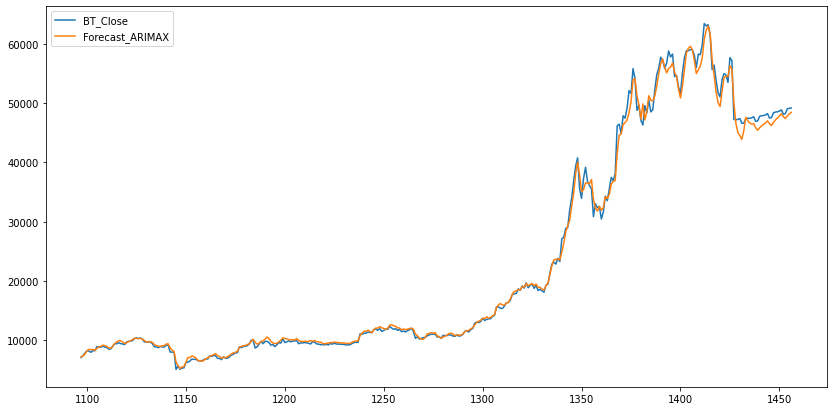

In [241]:
model = auto_arima(df_full_train.BT_Close, exogenous=df_full_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_full_train.BT_Close, exogenous=df_full_train[exogenous_features])

forecast = model.predict(n_periods=len(df_full_valid), exogenous=df_full_valid[exogenous_features])
df_full_valid["Forecast_ARIMAX"] = forecast

df_full_valid[["BT_Close", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_full_valid.BT_Close, df_full_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_full_valid.BT_Close, df_full_valid.Forecast_ARIMAX))

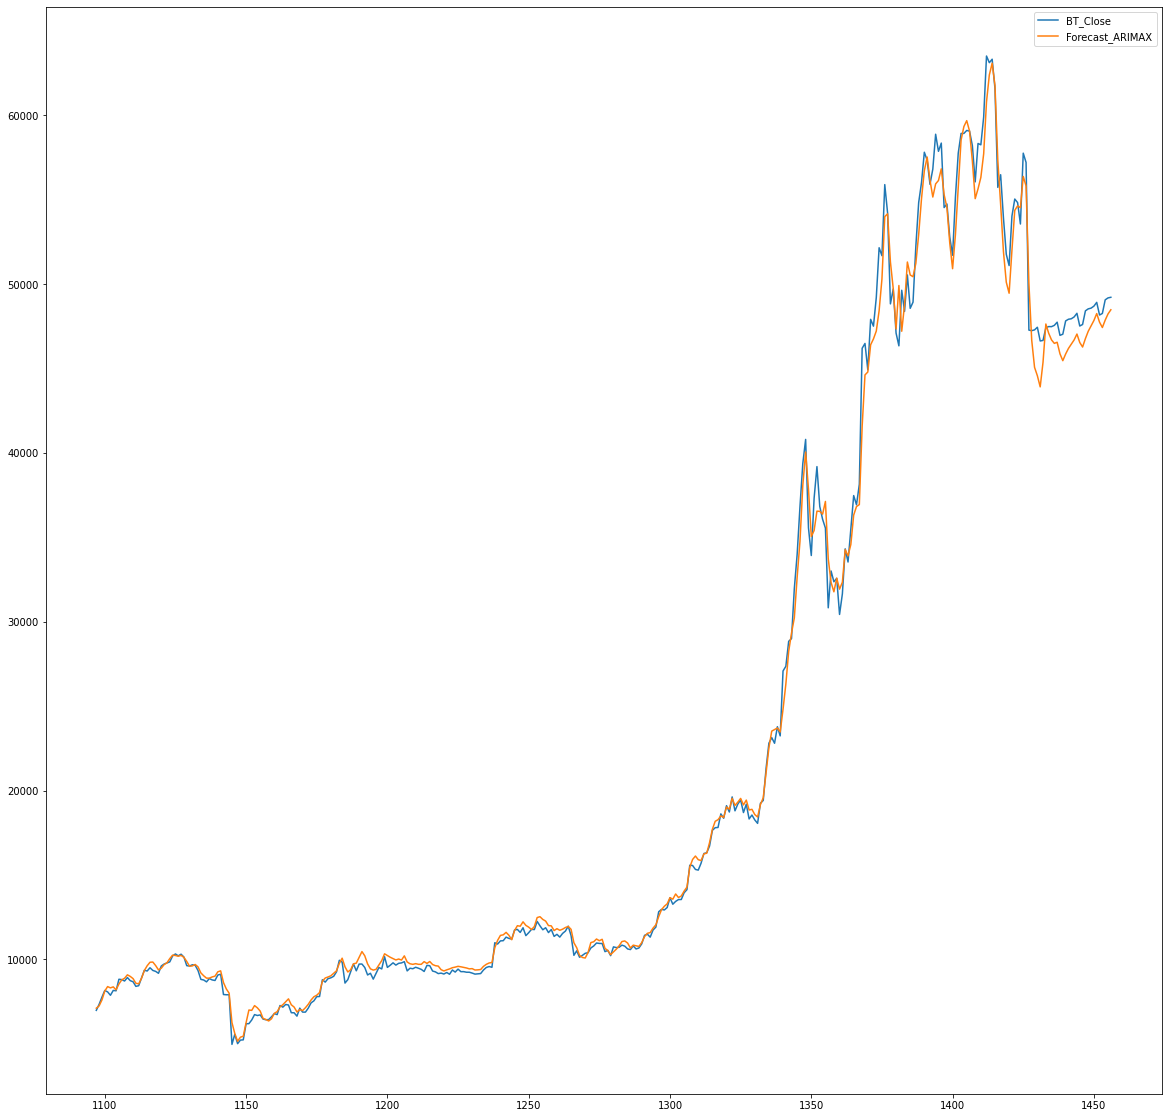

In [243]:
df_full_valid[["BT_Close", "Forecast_ARIMAX"]].plot(figsize=(20, 20))

In [244]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_full_valid.BT_Close, df_full_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_full_valid.BT_Close, df_full_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 923.5659427525478

MAE of Auto ARIMAX: 582.9540904115808


In [247]:
df_full_valid.loc[1420:]

,Date,BT_Close,BT_Volume,ETH_Close,ETH_Volume,GSPC_Close,GSPC_Volume,GCF_Close,year,month,week,weekday,EMA21,EMA63,EMA252,MA21,MA63,MA252,MA63_STD,Bollinger_Upper_MVS,Bollinger_Lower_MVS,MACD,RSI21,RSI63,RSI252,Forecast_ARIMAX
1420,2021-04-23,51093.652344,8.666867e+10,2363.586182,5.541393e+10,4180.169922,3.568080e+09,1777.000000,2021,4,16,23,54969.227226,56347.601973,44286.714719,56263.730469,57285.354531,42366.432528,3565.547214,64416.448958,50154.260104,-1378.374747,99.771462,99.875421,99.851778,49455.171140
1421,2021-04-26,54021.753906,5.828404e+10,2534.481689,3.520833e+10,4187.620117,3.738920e+09,1779.199951,2021,4,17,26,54732.358896,56168.690583,44481.415503,54936.265067,57112.358594,42713.866043,3616.464621,64345.287836,49879.429352,-1436.331687,99.873976,99.887357,99.856617,51996.157278
1422,2021-04-27,55033.117188,4.944822e+10,2662.865234,3.227597e+10,4186.720215,3.703240e+09,1778.000000,2021,4,17,27,54807.548469,56081.338783,44692.449537,54002.026228,57132.517500,43079.826843,3602.844264,64338.206027,49926.828973,-1273.790314,99.878753,99.887986,99.857268,54360.717291
1423,2021-04-28,54824.703125,4.800057e+10,2746.380127,3.426903e+10,4183.180176,3.772390e+09,1773.199951,2021,4,17,28,54811.837133,55984.674502,44895.094608,53873.517299,57135.947813,43439.661301,3600.510427,64336.968667,49934.926958,-1172.837369,99.858574,99.883324,99.855814,54629.065450
1424,2021-04-29,53555.109375,4.608893e+10,2756.876953,3.257813e+10,4211.470215,4.288940e+09,1768.099976,2021,4,17,29,54497.655194,55797.784877,45068.294904,53456.671317,57167.181563,43784.203835,3564.301894,64295.785351,50038.577774,-1300.129683,99.835042,99.878468,99.854345,54519.795348
1425,2021-04-30,57750.175781,5.239593e+10,2773.207031,2.977718e+10,4181.169922,4.273680e+09,1767.300049,2021,4,17,30,55310.785340,55947.968793,45321.932521,54005.826451,57409.022187,44178.652423,3378.455386,64165.932959,50652.111416,-637.183452,99.910639,99.895590,99.861496,56371.001145
1426,2021-05-03,57200.292969,5.171314e+10,3431.086182,4.917429e+10,4192.660156,4.061170e+09,1791.400024,2021,5,18,3,55783.162248,56044.301422,45559.499730,54782.686384,57491.541406,44562.578303,3345.692046,64182.925499,50800.157314,-261.139174,99.895761,99.891244,99.860085,55810.356033
1427,2021-05-04,47271.878087,6.285672e+10,1853.896839,3.176099e+10,4085.601611,4.917982e+09,1827.125264,2021,5,18,4,53655.341207,55369.499627,45593.747297,54236.718633,57072.408561,44855.009955,3919.133261,64910.675083,49234.142039,-1714.158419,99.878408,99.886718,99.858659,50048.405411
1428,2021-05-05,47239.234055,6.338737e+10,1848.193757,3.176998e+10,4084.671674,5.000016e+09,1827.575661,2021,5,18,5,52051.314419,54744.094583,45626.657032,53267.787226,56605.270267,45144.760642,4361.103310,65327.476886,47883.063648,-2692.780163,99.858172,99.882003,99.857219,46671.668812
1429,2021-05-06,47284.877154,6.387063e+10,1845.288603,3.179000e+10,4083.317662,4.992604e+09,1829.100926,2021,5,18,6,50859.705103,54170.308627,45659.821435,52160.895792,56139.912072,45437.890793,4710.646335,65561.204741,46718.619403,-3310.603524,99.836338,99.877368,99.855860,45067.862306
